<a href="https://colab.research.google.com/github/MorningStarTM/brain_cancer_detection/blob/main/brain_tumor_classification_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing libraries
import os
import cv2
import itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from glob import glob
from tensorflow.keras.layers import*
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import*
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [2]:
#parameters
H, W = 224, 224
channel = 3
num_class = 3
batch_size = 64
class_names = ["glioma", "meningioma", "notumor", "pituitary"]

## Data Pipeline

In [3]:

def load_data(path, split=0.1):
    images = shuffle(glob(os.path.join(path, "*", "*.jpg")))
    
    split_size = int(len(images) * split)
    #split the data
    train_data, valid_data = train_test_split(images, test_size=split_size, random_state=42)
    train_data, test_data = train_test_split(train_data, test_size=split_size, random_state=42)

    return train_data, valid_data, test_data 

In [4]:
def process_image(path):
    #decode the path
    path = path.decode()
    #read image
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    #resize the image
    image = cv2.resize(image, [224, 224])
    #scale the image
    image = image / 255.0
    #change the data type of image
    image = image.astype(np.float32)

    #labeling the image
    class_name = path.split("/")[-2]
    class_idx = class_names.index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)

    return image, class_idx

In [5]:
def parse(path):
    image, labels = tf.numpy_function(process_image, [path], (tf.float32, tf.int32))
    labels = tf.one_hot(labels, 4)
    image.set_shape([224, 224, 3])
    labels.set_shape(4)
  
    return image, labels

In [6]:
#tensorflow dataset
def tf_dataset(images, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((images))
    dataset = dataset.map(parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(8)
    return dataset

In [7]:
#input layer
inputs = Input(shape=(W, H, channel))

In [19]:
#convolutional layer
conv_x = Conv2D(16, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(inputs)
conv_x = MaxPooling2D((2,2), strides=(2,2))(conv_x)
conv_x = Conv2D(16, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(conv_x)

conv_x = Conv2D(32, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(conv_x)
conv_x = MaxPooling2D((2,2), strides=(1,1))(conv_x)
conv_x = Conv2D(32, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(conv_x)

conv_x = Conv2D(64, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(conv_x)
conv_x = MaxPooling2D((2,2), strides=(2,2))(conv_x)
conv_x = Conv2D(64, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(conv_x)

conv_x = Conv2D(128, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(conv_x)
conv_x = MaxPooling2D((2,2), strides=(2,2))(conv_x)
conv_x = Conv2D(128, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(conv_x)

conv_x = Conv2D(256, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(conv_x)
conv_x = MaxPooling2D((2,2), strides=(2,2))(conv_x)
conv_x = Conv2D(256, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(conv_x)

conv_x = Conv2D(512, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(conv_x)
conv_x = MaxPooling2D((2,2), strides=(2,2))(conv_x)
conv_x = Conv2D(512, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(conv_x)

#flatting
flatten = Flatten()(conv_x)
conv_x = Dense(64, activation='relu')(flatten)

#adding Dense layer with number of class 
outputs = Dense(4, activation='softmax')(conv_x)

In [20]:
model = Model(inputs=inputs, outputs=outputs)

In [21]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 112, 112, 16)      2320      
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                       

In [11]:
#callbacks parameter //paths
model_path = "/content/drive/MyDrive/CNN_Models/brain_tumor_model_2.h5"
csv_path = "/content/drive/MyDrive/Model CSV/brain_tumor_1.csv"
    

In [12]:
#initalize callbacks
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    CSVLogger(csv_path),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_lr=1e-7, verbose=1)
]

In [22]:
#compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
#dataset path
path = "/content/drive/MyDrive/DataSet/brain_cancer/Training"

In [15]:
#split the dataset
x_train, x_valid, x_test = load_data(path)
print(f"Train:{len(x_train)} - Test:{len(x_test)} - Valid:{len(x_valid)}")

Train:4586 - Test:573 - Valid:573


In [16]:
#tensor dataset
train_df = tf_dataset(x_train)
test_df = tf_dataset(x_test)
valid_df = tf_dataset(x_valid)

In [23]:
model.fit(
    train_df,
    validation_data=valid_df,
    epochs=20,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/20
72/72 [==============================] - ETA: 0s - loss: 1.3711 - accuracy: 0.3522
Epoch 1: val_loss did not improve from 0.30297
72/72 [==============================] - 35s 379ms/step - loss: 1.3711 - accuracy: 0.3522 - val_loss: 1.1128 - val_accuracy: 0.5340 - lr: 0.0010
Epoch 2/20
72/72 [==============================] - ETA: 0s - loss: 0.7331 - accuracy: 0.7002
Epoch 2: val_loss did not improve from 0.30297
72/72 [==============================] - 31s 426ms/step - loss: 0.7331 - accuracy: 0.7002 - val_loss: 0.6346 - val_accuracy: 0.7784 - lr: 0.0010
Epoch 3/20
72/72 [==============================] - ETA: 0s - loss: 0.4978 - accuracy: 0.8072
Epoch 3: val_loss did not improve from 0.30297
72/72 [==============================] - 30s 417ms/step - loss: 0.4978 - accuracy: 0.8072 - val_loss: 0.4626 - val_accuracy: 0.8290 - lr: 0.0010
Epoch 4/20
72/72 [==============================] - ETA: 0s - loss: 0.4156 - accuracy: 0.8397
Epoch 4: val_loss did not improve from 0.30297
7

In [24]:
model.evaluate(test_df)

9/9 [==============================] - 3s 311ms/step - loss: 0.2344 - accuracy: 0.9494


[0.23436440527439117, 0.9493891596794128]

In [25]:
#plot confusion matrix
def plt_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_mark = np.arange(len(classes))
  plt.xticks(tick_mark, classes, rotation=45)
  plt.yticks(tick_mark, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.axis]
    print("normalized confusion matrix")

  else:
    print("confusion matrix without normalization")
  
  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.xlabel("predicted label")
  plt.ylabel("True label")

In [26]:
#prediction
prediction = model.predict(test_df, verbose=0)

In [27]:
#scale the predicted value
np.around(prediction)

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [28]:
#get the max value 
y_pred_classes = np.argmax(prediction, axis=1)

In [29]:
#function for get labels of test set
def get_test_data_class(test_path):
  names = []
  for i in test_path:
    name = i.split("/")[-2]
    name_idx = class_names.index(name)
    names.append(name_idx)
  names = np.array(names, dtype=np.int32)
  return names

In [30]:
classes = get_test_data_class(x_test)

In [31]:
#confusion matrix
cm = confusion_matrix(y_true=classes, y_pred=y_pred_classes)

confusion matrix without normalization


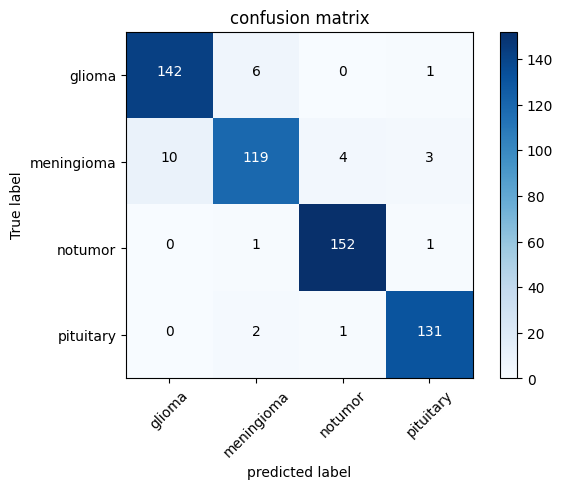

In [32]:
plt_confusion_matrix(cm=cm, classes=class_names, title="confusion matrix", )